# LSTM et Attention


Dans ce notebook, le but sera de faire de la reconnaissance d'entités nommées en utilisant le modèle d'attention associé au LSTM.

L'attention est décrit dans l'article de [Vaswani et al., 2017](https://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf). 

Nous allons utiliser plusieurs couches d'attention à l'aide de la méthode de PyTorch `MultiheadAttention`.

In [1]:
!pip install torchtext==0.6.0
!pip install pytorch-crf

import time
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.optim import Adam
from torchtext.data import Field, NestedField, BucketIterator
from torchtext.datasets import SequenceTaggingDataset
from torchtext.vocab import Vocab
from torchcrf import CRF
from collections import Counter
import torch.optim as optim

from torchtext import data
from torchtext import datasets

import spacy
from torchcrf import CRF
import numpy as np
import pandas as pd

import time
import random
import string
from itertools import chain

# Préparer les données


In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(lower = True) 
TAG = data.Field(unk_token = None) 
CHAR_NESTING= Field(tokenize=list)
CHAR = NestedField(CHAR_NESTING) 

train_data, valid_data, test_data = data.TabularDataset.splits(
        path="data_ner/",
        train="train.csv",
        validation="valid.csv",
        test="test.csv", format='csv', skip_header=True,
        fields=(
            (("text", "char"), (TEXT, CHAR)), 
            ("tag", TAG)
        )
    )

MIN_FREQ = 2

TEXT.build_vocab(train_data, 
                 min_freq = MIN_FREQ, # les mots qui apparaissent moins que MIN_FREQ fois seront ignorés du vocabulaire
                 vectors = "glove.6B.300d",
                 unk_init = torch.Tensor.normal_)


TAG.build_vocab(train_data)
CHAR.build_vocab(train_data) 
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device, sort=False)

# padding index
TEXT_PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
CHAR_PAD_IDX = CHAR.vocab.stoi[CHAR.pad_token]  
TAG_PAD_IDX = TAG.vocab.stoi[TAG.pad_token]

# Construire le modèle

On ajoute une nouvelle couche à notre modèle. On utilise le module de PyTorch `MultiheadAttention`, qui est une implémentation du mécanisme d'attention décrit dans [cet article](https://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf). 

Les inputs (*query*, *key*, and *value*) pour la couche d'attention sont les mêmes : la sortie du LSTM.

In [3]:
class BiLSTM(nn.Module):

    def __init__(self,
                 input_dim,
                 embedding_dim,
                 char_emb_dim,
                 char_input_dim,
                 char_cnn_filter_num,
                 char_cnn_kernel_size,
                 hidden_dim,
                 output_dim,
                 lstm_layers,
                 attn_heads,
                 emb_dropout,
                 cnn_dropout,
                 lstm_dropout,
                 attn_dropout,
                 fc_dropout,
                 word_pad_idx,  
                 char_pad_idx,
                 tag_pad_idx):
        super().__init__()
        self.char_pad_idx = char_pad_idx  
        self.word_pad_idx = word_pad_idx  
        self.tag_pad_idx = tag_pad_idx  
        
        # LAYER 1A: Word Embedding
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim=embedding_dim,
            padding_idx=word_pad_idx
        )
        self.emb_dropout = nn.Dropout(emb_dropout)
        
        # LAYER 1B: Char Embedding-CNN
        self.char_emb_dim = char_emb_dim
        self.char_emb = nn.Embedding(
            num_embeddings=char_input_dim,
            embedding_dim=char_emb_dim,
            padding_idx=char_pad_idx
        )
        self.char_cnn = nn.Conv1d(
            in_channels=char_emb_dim,
            out_channels=char_emb_dim * char_cnn_filter_num,
            kernel_size=char_cnn_kernel_size,
            groups=char_emb_dim 
        )
        self.cnn_dropout = nn.Dropout(cnn_dropout)
        
        # LAYER 2: BiLSTM
        self.lstm = nn.LSTM(
            input_size=embedding_dim + (char_emb_dim * char_cnn_filter_num),
            hidden_size=hidden_dim,
            num_layers=lstm_layers,
            bidirectional=True,
            dropout=lstm_dropout if lstm_layers > 1 else 0
        )
        
        # LAYER 3: Self-attention
        self.attn = nn.MultiheadAttention(
            embed_dim=hidden_dim * 2,
            num_heads=attn_heads,
            dropout=attn_dropout
        )
        
        # LAYER 4: Fully-connected
        self.fc_dropout = nn.Dropout(fc_dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim) 
        

        for name, param in self.named_parameters():
            nn.init.normal_(param.data, mean=0, std=0.1)

    def forward(self, words, chars, tags=None):
        # words = [sentence length, batch size]
        # chars = [batch size, sentence length, word length)
        # tags = [sentence length, batch size]
        
        # embedding_out = [sentence length, batch size, embedding dim]
        embedding_out = self.emb_dropout(self.embedding(words))

        # char_emb_out = [batch size, sentence length, word length, char emb dim]
        char_emb_out = self.emb_dropout(self.char_emb(chars))
        batch_size, sent_len, word_len, char_emb_dim = char_emb_out.shape
        char_cnn_max_out = torch.zeros(batch_size, sent_len, self.char_cnn.out_channels)
        for sent_i in range(sent_len):
            
            # sent_char_emb = [batch size, word length, char emb dim]
            sent_char_emb = char_emb_out[:, sent_i, :, :]
            
            # sent_char_emb_p = [batch size, char emb dim, word length]
            sent_char_emb_p = sent_char_emb.permute(0, 2, 1)
            
            # char_cnn_sent_out = [batch size, out channels * char emb dim, word length - kernel size + 1]
            char_cnn_sent_out = self.char_cnn(sent_char_emb_p)
            char_cnn_max_out[:, sent_i, :], _ = torch.max(char_cnn_sent_out, dim=2)
        char_cnn = self.cnn_dropout(char_cnn_max_out)

        # char_cnn_p = [sentence length, batch size, char emb dim * num filter]
        char_cnn_p = char_cnn.permute(1, 0, 2).to(device)
        word_features = torch.cat((embedding_out, char_cnn_p), dim=2)
        
        # lstm_out = [sentence length, batch size, hidden dim * 2]
        lstm_out, _ = self.lstm(word_features)
        
        # crée mask pour padding
        # key_padding_mask = [batch size, sentence length]
        key_padding_mask = torch.as_tensor(words == self.word_pad_idx).permute(1, 0)
        
        # attn_out = [sentence length, batch size, hidden dim * 2]
        # attn_weight = [batch size, sentence length, sentence length]
        attn_out, attn_weight = self.attn(lstm_out, lstm_out, lstm_out, key_padding_mask=key_padding_mask)
        
        # fc_out = [sentence length, batch size, output dim]
        fc_out = self.fc(self.fc_dropout(attn_out))
        
        return fc_out, attn_weight

    def init_embeddings(self, char_pad_idx, word_pad_idx, pretrained=None, freeze=True):
        self.embedding.weight.data[word_pad_idx] = torch.zeros(self.embedding_dim)
        self.char_emb.weight.data[char_pad_idx] = torch.zeros(self.char_emb_dim)
        if pretrained is not None:
            self.embedding = nn.Embedding.from_pretrained(
                embeddings=torch.as_tensor(pretrained),
                padding_idx=word_pad_idx,
                freeze=freeze
            )
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [4]:
model = BiLSTM(
    input_dim=len(TEXT.vocab),
    embedding_dim=300,
    char_emb_dim=25,
    char_input_dim=len(CHAR.vocab),
    char_cnn_filter_num=5,
    char_cnn_kernel_size=3,
    hidden_dim=64,
    output_dim=len(TAG.vocab),
    lstm_layers=2,
    attn_heads=16,
    emb_dropout=0.5,
    cnn_dropout=0.25,
    lstm_dropout=0.1,
    attn_dropout=0.25,
    fc_dropout=0.25,
    word_pad_idx=TEXT_PAD_IDX,
    char_pad_idx=CHAR_PAD_IDX,
    tag_pad_idx=TAG_PAD_IDX
)

model.init_embeddings(
    char_pad_idx=CHAR_PAD_IDX,
    word_pad_idx=TEXT_PAD_IDX,
    pretrained= TEXT.vocab.vectors,
    freeze=True
)

print(f"Le modèle a {model.count_parameters():,} paramètres à entraîner.")


Le modèle a 318,308 paramètres à entraîner.


# Entraînement

 - Optimiseur et fonction loss

In [5]:
optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)

model = model.to(device)
criterion = criterion.to(device)

 - Métriques

In [6]:
from sklearn.metrics import f1_score
def f1_loss(preds, y, tag_pad_idx):
    index_o = TAG.vocab.stoi["O"]
    positive_labels = [i for i in range(len(TAG.vocab.itos))
                           if i not in (tag_pad_idx, index_o)]
    _, pred = torch.max(preds, 1)
    pred = pred.data.cpu().numpy() 
    tags = y.data.cpu().numpy()
    f1 = f1_score(
            y_true=tags,
            y_pred=pred,
            labels=positive_labels,
            average="micro"
        ) 
       
    return f1

def accuracy_per_tag(predictions, tags):
    n_tags = len(TAG.vocab)
    class_correct = list(0 for i in range(n_tags))
    class_total = list(0 for i in range(n_tags))
    acc = list(0 for i in range(n_tags))
    _, pred = torch.max(predictions, 1)
    # # compare predictions to true label
    correct = np.squeeze(pred.eq(tags.data.view_as(pred)))
    # # calculate test accuracy for each object class
    for i in range(BATCH_SIZE):
        label = tags.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    for i in range(n_tags):
        if np.sum(class_total[i]) == 0 and np.sum(class_correct[i]) ==0:
            res = 100
        else:
            res = 100 * class_correct[i] / class_total[i]
        acc[i] = res, np.sum(class_correct[i]), np.sum(class_total[i])
        
    return acc  

In [19]:
def train(model, iterator, optimizer, criterion, tag_pad_idx):
    
    epoch_loss = 0
    epoch_f1 = 0
    
    model.train()
    
    for batch in iterator:
        
        text = batch.text
        tags = batch.tag
        chars = batch.char 
        optimizer.zero_grad()

        predictions, _ = model(text,chars)
        
        #predictions = [sent len, batch size, output dim]
        #tags = [sent len, batch size]
        
        predictions = predictions.view(-1, predictions.shape[-1])
        tags = tags.view(-1)
        
        #predictions = [sent len * batch size, output dim]
        #tags = [sent len * batch size]
        
        loss = criterion(predictions, tags)
                
        f1 = f1_loss(predictions, tags, tag_pad_idx)
        acc = accuracy_per_tag(predictions, tags)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_f1 += f1.item()
        
    return epoch_loss / len(iterator), acc, epoch_f1 / len(iterator)

def evaluate(model, iterator, criterion, tag_pad_idx):
    
    epoch_loss = 0
    epoch_f1 = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text = batch.text
            tags = batch.tag
            chars = batch.char
            
            predictions,_ = model(text,chars)
            
            predictions = predictions.view(-1, predictions.shape[-1])
            tags = tags.view(-1)
            
            loss = criterion(predictions, tags)
            acc = accuracy_per_tag(predictions, tags)
            f1 = f1_loss(predictions, tags, tag_pad_idx)

            epoch_loss += loss.item()
            epoch_f1 += f1.item()
        
    return epoch_loss / len(iterator), acc, epoch_f1 / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc, train_f1 = train(model, train_iterator, optimizer, criterion, TAG_PAD_IDX)
    valid_loss, valid_acc, valid_f1 = evaluate(model, valid_iterator, criterion, TAG_PAD_IDX)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    if epoch%5 == 0:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train F1 score: {train_f1*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. F1 score: {valid_f1*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 17s
	Train Loss: 0.115 | Train F1 score: 65.83%
	 Val. Loss: 0.091 |  Val. F1 score: 81.47%
Epoch: 06 | Epoch Time: 0m 16s
	Train Loss: 0.080 | Train F1 score: 68.38%
	 Val. Loss: 0.076 |  Val. F1 score: 74.52%


In [20]:
n_tags = len(TAG.vocab)
for i in range(n_tags):   
    print('Train Accuracy of %5s: %2d%% (%2d/%2d)' % (
           TAG.vocab.itos[i], train_acc[i][0],
           train_acc[i][1], train_acc[i][2]))  

Train Accuracy of <pad>: 100% ( 0/ 0)
Train Accuracy of     O: 98% (78/79)
Train Accuracy of B-LOC: 100% (10/10)
Train Accuracy of B-PER: 100% (16/16)
Train Accuracy of B-ORG: 94% (18/19)
Train Accuracy of I-PER: 100% ( 0/ 0)
Train Accuracy of I-ORG: 100% ( 0/ 0)
Train Accuracy of B-MISC: 50% ( 2/ 4)
Train Accuracy of I-LOC: 100% ( 0/ 0)
Train Accuracy of I-MISC: 100% ( 0/ 0)


In [21]:
for i in range(n_tags):
    print('Valid Accuracy of %5s: %2d%% (%2d/%2d)' % (
           TAG.vocab.itos[i], valid_acc[i][0],
           valid_acc[i][1], valid_acc[i][2]))
  

Valid Accuracy of <pad>:  0% ( 0/19)
Valid Accuracy of     O: 100% (93/93)
Valid Accuracy of B-LOC: 100% ( 1/ 1)
Valid Accuracy of B-PER: 100% ( 2/ 2)
Valid Accuracy of B-ORG: 85% ( 6/ 7)
Valid Accuracy of I-PER: 100% ( 2/ 2)
Valid Accuracy of I-ORG: 100% ( 4/ 4)
Valid Accuracy of B-MISC: 100% ( 0/ 0)
Valid Accuracy of I-LOC: 100% ( 0/ 0)
Valid Accuracy of I-MISC: 100% ( 0/ 0)


In [22]:
model.load_state_dict(torch.load('tut4-model.pt'))

test_loss, test_acc, test_f1 = evaluate(model, test_iterator, criterion, TAG_PAD_IDX)
n_tags = len(TAG.vocab)
for i in range(n_tags):   
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
           TAG.vocab.itos[i], test_acc[i][0],
           test_acc[i][1], test_acc[i][2]))
print(f'Test Loss: {test_loss:.3f} |  Test F1 score: {test_f1*100:.2f}%')

Test Accuracy of <pad>:  0% ( 0/ 2)
Test Accuracy of     O: 100% (56/56)
Test Accuracy of B-LOC: 72% ( 8/11)
Test Accuracy of B-PER: 66% ( 4/ 6)
Test Accuracy of B-ORG: 93% (41/44)
Test Accuracy of I-PER: 100% ( 0/ 0)
Test Accuracy of I-ORG: 50% ( 2/ 4)
Test Accuracy of B-MISC: 100% ( 2/ 2)
Test Accuracy of I-LOC: 66% ( 2/ 3)
Test Accuracy of I-MISC: 100% ( 0/ 0)
Test Loss: 0.126 |  Test F1 score: 70.04%


On peut visualiser les poids d'attention.

In [23]:
def visualize_attn(tokens, weights):
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(weights, cmap=plt.get_cmap("gray"))
    ax.set_xticks(list(range(len(tokens))))
    ax.set_yticks(list(range(len(tokens))))
    ax.set_xticklabels(tokens)
    ax.set_yticklabels(tokens)
    # Create colorbar
    _ = ax.figure.colorbar(im, ax=ax)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
                 rotation_mode="anchor")
    plt.tight_layout()
    plt.show()



def tag_sentence(model, device, sentence, text_field, tag_field, char_field):
 
    model.eval()
    
    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text for token in nlp(sentence)]
    else:
        tokens = [token for token in sentence]

    if text_field.lower:
        tokens = [t.lower() for t in tokens]
        
    max_word_len = max([len(token) for token in tokens])
    numericalized_chars = []
    char_pad_id = char_field.vocab.stoi[CHAR.pad_token] 
    for token in tokens:
        numericalized_chars.append(
                [char_field.vocab.stoi[char] for char in token]
                + [char_pad_id for _ in range(max_word_len - len(token))]
                )
    numericalized_tokens = [text_field.vocab.stoi[t] for t in tokens]
    unk_idx = text_field.vocab.stoi[text_field.unk_token]  
    unks = [t for t, n in zip(tokens, numericalized_tokens) if n == unk_idx]
    
    token_tensor = torch.LongTensor(numericalized_tokens)    
    token_tensor = token_tensor.unsqueeze(-1).to(device)
    char_tensor = torch.as_tensor(numericalized_chars)
    char_tensor = char_tensor.unsqueeze(0).to(device) 
    predictions, attn_weight = model(token_tensor, char_tensor)
    visualize_attn(tokens, attn_weight.detach().cpu().numpy()[0])
    
    top_predictions = predictions.argmax(-1)
    
    predicted_tags = [tag_field.vocab.itos[t.item()] for t in top_predictions]
    
    return tokens, predicted_tags, unks

['"', 'we', 'do', "n't", 'support', 'any', 'such', 'recommendation', 'because', 'we', 'do', "n't", 'see', 'any', 'grounds', 'for', 'it', ',', '"', 'the', 'commission', "'s", 'chief', 'spokesman', 'nikolaus', 'van', 'der', 'pas', 'told', 'a', 'news', 'briefing', '.']


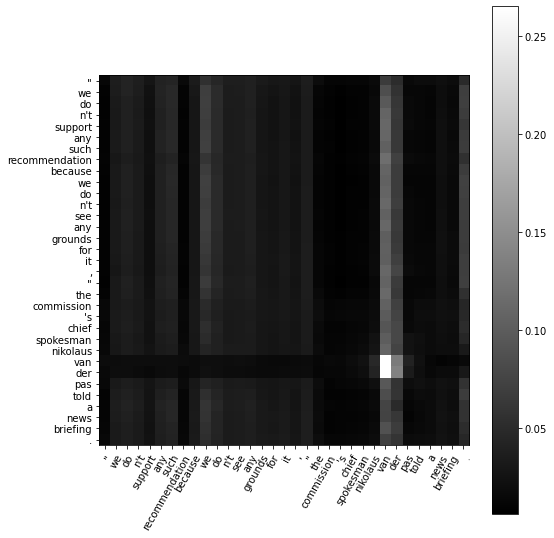

Pred. Tag	Actual Tag	Correct?	Token

O		O		✔		"
O		O		✔		we
O		O		✔		do
O		O		✔		n't
O		O		✔		support
O		O		✔		any
O		O		✔		such
O		O		✔		recommendation
O		O		✔		because
O		O		✔		we
O		O		✔		do
O		O		✔		n't
O		O		✔		see
O		O		✔		any
O		O		✔		grounds
O		O		✔		for
O		O		✔		it
O		O		✔		,
O		O		✔		"
O		O		✔		the
O		B-ORG		✘		commission
O		O		✔		's
O		O		✔		chief
O		O		✔		spokesman
O		B-PER		✘		nikolaus
B-PER		I-PER		✘		van
I-PER		I-PER		✔		der
O		I-PER		✘		pas
O		O		✔		told
O		O		✔		a
O		O		✔		news
O		O		✔		briefing
O		O		✔		.


In [24]:
example_index = 6

sentence = vars(train_data.examples[example_index])['text']
actual_tags = vars(train_data.examples[example_index])['tag']

print(sentence)
tokens, pred_tags, unks = tag_sentence(model, 
                                       device, 
                                       sentence, 
                                       TEXT, 
                                       TAG,
                                       CHAR)

print("Pred. Tag\tActual Tag\tCorrect?\tToken\n")

for token, pred_tag, actual_tag in zip(tokens, pred_tags, actual_tags):
    correct = '✔' if pred_tag == actual_tag else '✘'
    print(f"{pred_tag}\t\t{actual_tag}\t\t{correct}\t\t{token}")

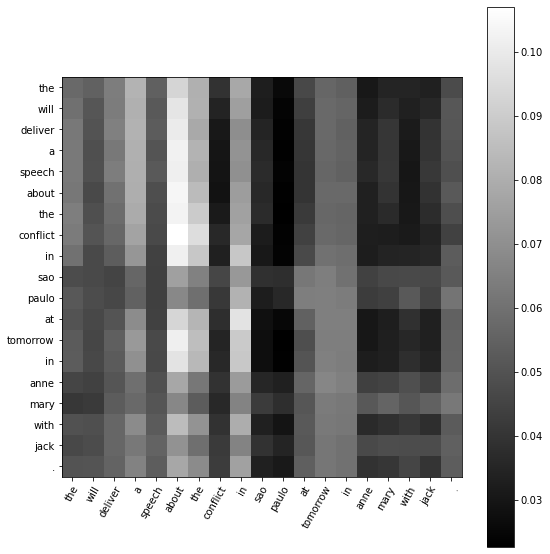

[]
Pred. Tag	Token

O		the
O		will
O		deliver
O		a
O		speech
O		about
O		the
O		conflict
O		in
O		sao
O		paulo
O		at
O		tomorrow
O		in
O		anne
O		mary
O		with
O		jack
O		.


In [25]:
sentence = 'The will deliver a speech about the conflict in Sao Paulo at tomorrow in Anne Mary with Jack.'

tokens, tags, unks = tag_sentence(model, 
                                  device, 
                                  sentence, 
                                  TEXT, 
                                  TAG,
                                  CHAR)

print(unks)
print("Pred. Tag\tToken\n")


for token, tag in zip(tokens, tags):
    print(f"{tag}\t\t{token}")